# Model Development

## Load and Inspect the Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

In [3]:
cleaned_dataset = pd.read_csv("data/cleaned_dataset.csv")

In [4]:
# make a copy of the dataset
dataset = cleaned_dataset.copy()

## Model development for Returning Customer (Classification Model)

In [5]:
# Define features (drop non-useful columns and target)
X = dataset.drop(columns=[
    'cus.id', 'date', 'cus._location',  
    'did_he/she_buy_any_mobile_before'  # target variable
])
y = dataset['did_he/she_buy_any_mobile_before']

In [6]:
X

,age,gender,sell_price,does_he/she_come_from_facebook_page,does_he/she_followed_our_page,did_he/she_hear_of_our_shop_before,is_local,mobile_name_Galaxy M35 5G 8/128,mobile_name_Galaxy S24 Ultra 12/256,mobile_name_Moto G85 5G 8/128,...,mobile_name_Pixel 7a 8/128,mobile_name_Pixel 8 Pro 12/256,mobile_name_R-70 Turbo 5G 6/128,mobile_name_Redmi Note 12 Pro 8/128,mobile_name_Vivo T3x 5G 8/128,mobile_name_Vivo Y200 5G 6/128,mobile_name_iPhone 16 Pro 256GB,mobile_name_iPhone 16 Pro Max 1TB,mobile_name_iQOO Neo 9 Pro 5G 12/256,mobile_name_iQOO Z7 5G 6/128
0,49,0,17073.0,0,1,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,44,1,15546.0,1,0,1,0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,45,1,26516.0,1,0,1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,46,1,21927.0,0,0,1,0,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,27,0,16718.0,1,0,1,1,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8866,34,1,21682.0,1,1,1,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8867,48,1,26493.0,0,0,0,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
8868,30,0,16184.0,0,0,0,0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
8869,22,0,16663.0,1,0,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
y

0       0
1       0
2       0
3       0
4       0
       ..
8866    1
8867    0
8868    0
8869    0
8870    1
Name: did_he/she_buy_any_mobile_before, Length: 8871, dtype: int64

### Train/test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Standardize numeric features

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
X_train_scaled

array([[ 0.82942455,  1.00169253, -0.18326668, ..., -0.24408793,
        -0.24441186,  3.96187715],
       [-0.63455016, -0.99831033, -0.34417647, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [ 1.0385638 ,  1.00169253, -0.10128864, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       ...,
       [-0.73911978, -0.99831033,  0.01811534, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [-0.73911978,  1.00169253,  0.0521686 , ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [-0.73911978, -0.99831033,  0.15247882, ..., -0.24408793,
        -0.24441186, -0.2524056 ]])

In [11]:
X_test_scaled

array([[-1.05282865,  1.00169253, -0.48833161, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [ 1.45684229, -0.99831033, -0.23510814, ..., -0.24408793,
        -0.24441186,  3.96187715],
       [-1.15739827,  1.00169253, -0.51335477, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       ...,
       [-0.21627167,  1.00169253, -0.51868579, ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [-0.94825903, -0.99831033, -0.0875259 , ..., -0.24408793,
        -0.24441186, -0.2524056 ],
       [-1.05282865, -0.99831033,  0.00489659, ..., -0.24408793,
        -0.24441186, -0.2524056 ]])

### Apply SMOTE to Training Set

In [12]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

### Define and Train Models

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

In [14]:
results = {}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"\n==== {name} ====")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    results[name] = {
        'model': model,
        'roc_auc': roc_auc,
        'f1_score': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    }


==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.76      0.52      0.62      1336
           1       0.26      0.51      0.34       439

    accuracy                           0.51      1775
   macro avg       0.51      0.51      0.48      1775
weighted avg       0.64      0.51      0.55      1775

ROC-AUC: 0.5141

==== Random Forest ====
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1336
           1       0.24      0.20      0.22       439

    accuracy                           0.64      1775
   macro avg       0.49      0.50      0.49      1775
weighted avg       0.62      0.64      0.63      1775

ROC-AUC: 0.5036

==== XGBoost ====
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1336
           1       0.27      0.13      0.18       439

    accuracy                           0.70      1775
   macro avg       0.

### Visualize Confusion Matrix for Best Model

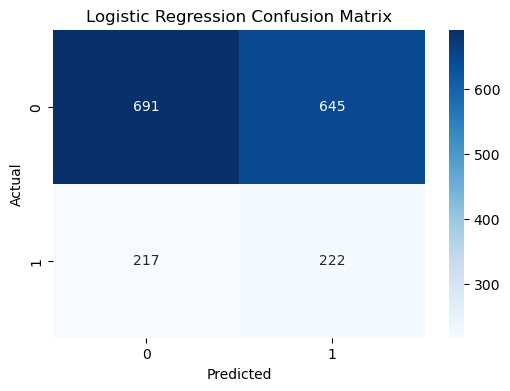

In [15]:
best_model = max(results, key=lambda x: results[x]['roc_auc'])
y_pred_best = results[best_model]['model'].predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_model} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()